In [11]:
# This file provides a small self-contained demonstration of a Gaussian process
# model. The model really is just a Gaussian distribution! A few lines of
# standard linear algebra give the conditional distributions you need to perform
# inference. You will probably need to invest some effort to understanding this
# demonstration, and working out the correspondence to the maths in the notes.
# No matter what I provide, you'll need to do some hard work. But once you've
# reproduced the ideas for yourself you should find that nothing that
# complicated is going on.
#
# Alternatively, gp_altdemo.py is a simpler demo, in that it requires less
# linear algebra, but I've used a non-standard presentation to achieve that
# trick: it will still require thought!
#
# One messy detail that we do encounter is that large covariance matrices
# constructed from the Gaussian kernel are poorly-conditioned. This script
# applies a standard hack to work around that.
#
# The class notes link to several polished and featureful Gaussian process
# toolboxes. These hide the maths from you behind user-friendly interfaces,
# and come with more extensive demonstrations.
#
# Iain Murray, November 2016

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

rng = np.random.RandomState(1)

In [12]:
## The kernel function
######################################################################

# This demo uses a Gaussian kernel function,
# k(x1,x2) = sigma_f**2 * np.exp(-0.5 * np.sum(((x1-x2)/ell)**2))

# We create kernel functions that take NxD and MxD design matrices, to give NxM
# kernel values. rbf_fn is a fixed unit bandwidth RBF kernel, and
# gauss_kernel_fn rescales that using free parameters ell (1xD or 1x1) and sigma_f (1x1).

rbf_fn = lambda X1, X2: \
        np.exp((np.dot(X1,(2*X2.T))-np.sum(X1*X1,1)[:,None]) - np.sum(X2*X2,1)[None,:])
gauss_kernel_fn = lambda X1, X2, ell, sigma_f: \
        sigma_f**2 * rbf_fn(X1/(np.sqrt(2)*ell), X2/(np.sqrt(2)*ell))

# Pick some particular parameters for this demo:
k_fn = lambda X1, X2: gauss_kernel_fn(X1, X2, 3.0, 10.0)

# You could also try:
# k_fn = lambda X1, X2: gauss_kernel_fn(X1, X2, 0.5, 1.0)
# k_fn = lambda X1, X2: gauss_kernel_fn(X1, X2, 0.5, 1.0) + gauss_kernel_fn(X1, X2, 3.0, 10.0)
# ...

# gauss_kernel_fn is equivalent to the following slower function:
def gauss_kernel_naive(X1, X2, ell, sigma_f):
    N, M = X1.shape[0], X2.shape[0]
    K = np.zeros((N, M))
    for n in range(N):
        for m in range(M):
            K[n,m] = sigma_f**2 * np.exp(
                    -0.5*np.sum(((X1[n,:]-X2[m,:])/ell)**2))
    return K


Text(0, 0.5, 'f')

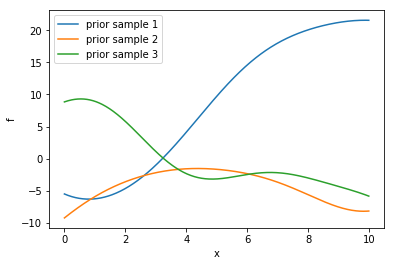

In [16]:
## Sampling from the prior
######################################################################

# Pick the input locations that we want to see the function at.
X_grid = np.arange(0, 10, 0.02)[:,None]

# Compute covariance of function values for those points. The Gaussian kernel
# gives positive definite matrices in theory. In practice, we need to add a tiny
# amount of noise to the process (a "jitter" or "nugget" term) if we need a
# matrix that is positive definite given finite numerical precision.
N_grid = X_grid.shape[0]
K_grid = k_fn(X_grid, X_grid) + 1e-9*np.eye(N_grid)

# To sample from Gausian with covariance K=L*L',
# we just multiply L by a vector standard normals:
L_grid = np.linalg.cholesky(K_grid)
plt.figure(1)
plt.clf()
for ii in range(3):
    f_grid = np.dot(L_grid, rng.randn(N_grid))
    plt.plot(X_grid, f_grid, '-')

plt.legend(['prior sample 1', 'prior sample 2', 'prior sample 3'])
plt.xlabel('x')
plt.ylabel('f')

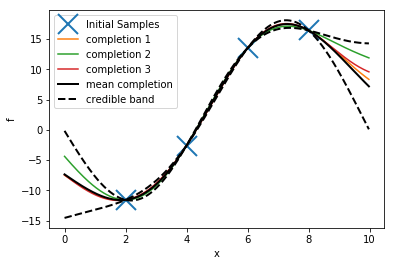

In [28]:
## Sampling from the prior in two stages
######################################################################

# We don't have to sample "the whole" function, or a dense grid.

# Pick four of the original grid points, just sample a setting of those and plot as crosses:
idx = np.round(N_grid*np.array([0.2,0.4,0.6,0.8])).astype(int)
X_locs1 = X_grid[idx, :]
N_locs1 = idx.size
K_locs1 = k_fn(X_locs1, X_locs1)
L_locs1 = np.linalg.cholesky(K_locs1)
plt.figure(2)
plt.clf()
noise_var = 0.0 # add no noise to the samples, we want to look at function values
#noise_var = 1.0 # add some noise to the samples, we want to simulate data
f_locs1 = np.dot(L_locs1, rng.randn(N_locs1)) + \
        np.sqrt(noise_var)*rng.randn(N_locs1)
plt.plot(X_locs1, f_locs1, 'x', markersize=20, markeredgewidth=2)

# We could later choose to sample any of the other function values, conditioned
# on the ones we already picked. We compute all the relevant covariances, and
# apply standard formulae to get the mean and covariance of the Gaussian over
# the remaining function values, conditioned on the ones we've already picked.
X_rest = np.delete(X_grid, idx, 0)
K_rest = k_fn(X_rest, X_rest)
K_rest_locs1 = k_fn(X_rest, X_locs1)
M = K_locs1 + noise_var*np.eye(N_locs1)
# We could compute cholesky(M) once and use it to solve both the linear systems in the next two lines
rest_cond_mu = np.dot(K_rest_locs1, np.linalg.solve(M, f_locs1))
rest_cond_cov = K_rest - np.dot(K_rest_locs1, np.linalg.solve(M, K_rest_locs1.T))

# Then we sample 3 different completions of the f_locs1 function values that we
# sampled above. Each completion by itself is just illustrating a sample of the
# function from the prior. The different completions illustrate different
# samples from the posterior at test locations, given a set of observed function
# values.
N_rest = X_rest.shape[0]
L_rest = np.linalg.cholesky(rest_cond_cov + 1e-9*np.eye(N_rest))
for ii in range(3):
    rest_sample = np.dot(L_rest, rng.randn(N_rest)) + rest_cond_mu
    plt.plot(X_rest, rest_sample, '-')

# If you change noise_var from 0.0 to 1.0 above, you can simulate first looking
# at noisy values of the function. The conditional distribution is then the
# posterior over some function values given some noisy observations.

# If you'd rather plot the mean prediction and error bars rather than samples,
# you can do that too. The thick black solid line shows the mean, and dashed
# thick black lines show +/- 2 standard deviations -- at any particular
# location, we have ~95% belief the function will lie in this range.
plt.plot(X_rest, rest_cond_mu, '-k', linewidth=2)
rest_cond_std = np.sqrt(np.diag(rest_cond_cov))
plt.plot(X_rest, rest_cond_mu + 2*rest_cond_std, '--k', linewidth=2)
plt.plot(X_rest, rest_cond_mu - 2*rest_cond_std, '--k', linewidth=2)
# The mean and error bars can be computed more cheaply if you don't want to know
# the whole posterior. See the notes.

plt.legend(['Initial Samples', 'completion 1', 'completion 2', 'completion 3',
        'mean completion', 'credible band'])
plt.xlabel('x')
plt.ylabel('f')
plt.show()


# Final remarks:
# --------------
# - None of the points have to be on a grid.
# - The initial training points X_locs1 could be anywhere.
# - The remaining test points X_rest could be anywhere.
# - If the points aren't sampled densely and in order, we wouldn't
#   join them with straight lines. We'd just plot individual points.
# - The inputs can be in D-dimensions. The kernel function is the
#   only part of the code that looks at the original input features.
#   None of the rest of the code cares where the scalar function
#   values are located in input space.
